# The Inverted Pendulum on a Cart Problem

## Introduction

## 1. System Dynamics and Equations of Motion

Previously we discussed how to derive the equations of motion for a cart balancing an inverted pendulum. Let's breifly repeat these steps for this project.

In [1]:
# Import everything we need from SymPy
import sympy as sym
import numpy as np
from sympy import Symbol, Matrix, Function, Derivative, N
from sympy import diff, simplify, sin, cos, solve, init_printing, symbols, lambdify
init_printing() # This function will make the outputs of SymPy look prettier and be easier to read

First off, we will define the system parameters, that is, the constants of the system.

In [2]:
# Parameters of the system
mp = 4.0      # Mass of the pendulum mass in kg
mc = 23.5     # Mass of the chassis in kg
mw = 1.8      # Mass of each wheel in kg
Izz = 0.01214 # Moment of inertial of each wheel about its rotational axis in kg-m^2
l = 1.0       # Length of the pendulum rod in m
r = 0.125     # Radius of each wheel in m
g = 9.81      # Acceleration due to gravity in m/s^2

Next we define the variables that we are going to use to define the equations of motion of the system.

In [21]:
# Time is a symbol (variable)
t = Symbol('t')

# The generalized coordinates and the input torque are both functions of time.
# This means that they are initialized as Functions.
theta = Function('theta')
phi = Function('phi')
tau = Function('tau') # The torque applied to each wheel (so that the total torque applied to the system is 4 tau)

After that, we start the Lagrangian mechanics approach to solving the equations of motion by calculating the kinetic and potential energy of the mass placed atop the pendulum arm.

In [4]:
# Get the position of the mass in terms of phi and theta
pos = Matrix([-r*phi(t) - l*sin(theta(t)), 0.0, l*cos(theta(t))])

# Take the derivative of the position with respect to time
vel = diff(pos,t)

# Get the kinetic energy of the mass from the velocity
mass_KE = 0.5 * mp * (vel.T @ vel)[0,0]

# Get the potential energy of the mass based on its position
mass_PE = mp*g*l*cos(theta(t))

We continue solving the equations of motion by calculating the kinetic energy of the chassis of the cart. Note we can ignore the cart's potential energy because it is constant.

In [5]:
# Get the position of the cart in terms of phi and theta
pos = Matrix([-phi(t)*r, 0.0, 0.0])

# Take the derivative of the position with respect to time
vel = diff(pos,t)

# Get the kinetic energy of the cart from the velocity
cart_KE = 0.5 * mc * (vel.T @ vel)[0,0]

Lastly, we get the kinetic and rotational energy of the wheels of the cart. Again, we ignore their potential energy because it is constant.

In [6]:
# Get the position of the wheels in terms of phi and theta
pos = Matrix([-phi(t)*r, 0.0, 0.0])

# Take the derivative of the position with respect to time
vel = diff(pos,t)

# Get the kinetic energy of all four wheels from the velocity
wheel_KE = 4.0 * (0.5 * mw * (vel.T @ vel)[0,0])

# Get the rotational kinetic energy of all four wheels
wheel_RE = 4.0*(Izz*diff(phi(t),t)**2)

After all the energies are calculated, we generate the ***lagrangian*** of the system, $L$, via the formula:$$L=T-V$$ where $T$ is the total kinetic energy and $V$ is the total potential energy.

System Lagrangian:


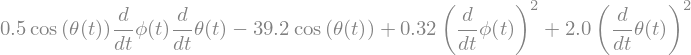

In [20]:
# Get the lagrangian
L = (mass_KE + cart_KE + wheel_KE + wheel_RE) - mass_PE
L = simplify(L)
print("System Lagrangian:")
N(L, 3) # This rounds floating point number to 3 places and then prints to the screen

To solve for the equations of motion, we solve the the Euler-Lagrange equations:
$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\theta}} \right) - \frac{\partial L}{\partial \theta}=0$$
$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\phi}} \right) - \frac{\partial L}{\partial \phi}=4\tau$$

In [22]:
# Get the left hand side of the first equation of motion
f1 = diff(diff(L, Derivative(theta(t), t)), t) - diff(L, theta(t))

# Get the left hand side of the second equation of motion
f2 = diff(diff(L, Derivative(phi(t), t)), t) - diff(L, phi(t)) - 4.0*tau(t)

In [23]:
# Solve the first two equations of motion for the second order derivatives
soln = solve([f1, f2], Derivative(theta(t), (t, 2)), Derivative(phi(t), (t, 2)))
soln = simplify(soln)
f_theta = soln[Derivative(theta(t), (t, 2))]
f_phi = soln[Derivative(phi(t), (t, 2))]

We can now place the equations of motion in a form that is more readable and print the results.

In [10]:
# Build the equations of motion vector
f = Matrix([f_theta, f_phi])

# Replace the functions of time with symbols
(v1, v2, v3, v4, v5) = symbols('v1, v2, v3, v4, v5')
f = f.subs({Derivative(theta(t), t) : v1,
            Derivative(phi(t), t) : v2,
            theta(t) : v3,
            phi(t) : v4,
            tau(t) : v5})
(thetadot, phidot, theta, phi, tau) = symbols('thetadot, phidot, theta, phi, tau')
f = f.subs({v1 : thetadot,
            v2 : phidot,
            v3 : theta,
            v4 : phi,
            v5 : tau})

# Simplify
f = simplify(f)

f(theta_dot, phi_dot, theta, phi, tau)=


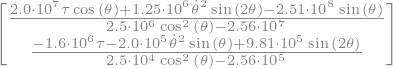

In [11]:
print('f(theta_dot, phi_dot, theta, phi, tau)=')
N(f, 3) # This rounds floating point number to 3 places and then prints to the screen

## 2. Standard Form

Just like last time, because we are using a model-based control approach, we will now convert these equations of motion to standard form:
$$
\dot{\mathbf{m}}=f(\mathbf{m}, \mathbf{n}).
$$

To begin, we need to replace both our *second order* differential equations with two *first order* differential equations. To do this, we can define two new variables: $\omega_{\theta}$ and $\omega_{\phi}$. We define these new variables via the differential equations:
$$
\dot{\theta} = \omega_{\theta} 
$$
$$
\dot{\phi} = \omega_{\phi}.
$$

In [24]:
# Create two new variables...
(omega_theta, omega_phi) = sym.symbols('omega_theta, omega_phi')

# and append them to the bottom of the system.
f = sym.Matrix([f[0], f[1], omega_theta, omega_phi])

Then, we replace all first order terms in the argument of $f$ with our newly defined zeroth order terms.

In [25]:
# Make a change of variables
f = f.subs({thetadot : omega_theta, phidot : omega_phi})

This gives us a system of equations in standard form:

f(m,n)=


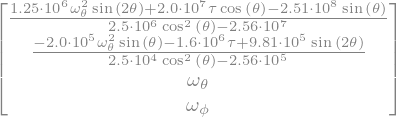

In [14]:
print('f(m,n)=')
sym.N(f, 3) # Display f in standard form

## 3. Linearizing the System

Again, we will approximate the nonlinear system dynamics near an equilibrium point by linearizing the system insto state space form:
$$
\dot{\mathbf{x}} = A\mathbf{x} + B\mathbf{u}.
$$
The first step in this process is choosing an equilibrium point about which to linearize the system.

In [16]:
# Convert symbolic system to a numeric function
f_num = sym.lambdify([omega_theta, omega_phi, theta, phi, tau], f)

# Choose the same equilibrium point as last time
omega_theta_e = 0.0 # To be stationary, the derivative of theta must be 0
omega_phi_e = 0.0   # To be stationary, the derivative of phi must be 0
theta_e = 0.0       # The pendulum balancing upright
phi_e = 0.0         # The cart at the starting position
tau_e = 0.0         # No torque applied to the wheels

In [26]:
# We can validate that our chosen state is a valid equilibrium point by ensuring the equations of motion are all 0 at it:
print('f(me,ne)=')
print(f_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e))

f(me,ne)=
[[-0.]
 [-0.]
 [ 0.]
 [ 0.]]


Next, we define the linear state vector, $\mathbf{x}$, the linear input vector $\mathbf{u}$, the state matrix, $A$, and the input matrix $B$ such that
\begin{align}
\mathbf{x} &= \mathbf{m} - \mathbf{m_{e}}\\
\mathbf{u} &= \mathbf{n} - \mathbf{n_{e}}\\
A &= \left.\frac{\partial f}{\partial \mathbf{m}}\right|_{\mathbf{m_{e}}, \mathbf{n_{e}}}\\
B &= \left.\frac{\partial f}{\partial \mathbf{n}}\right|_{\mathbf{m_{e}}, \mathbf{n_{e}}}\\
\end{align}

After this definition, we solve for $A$ and $B$.

In [17]:
# Define the nonlinear state vector
m = [omega_theta, omega_phi, theta, phi]

# Take the jacobian of f with respect to the nonlinear state vector
A_sym = f.jacobian(m)

# Convert the symbolic jacobian to a numeric representation
A_num = sym.lambdify([omega_theta, omega_phi, theta, phi, tau], A_sym)

# Evalulate the jacobian of f with respect to the nonlinear state vector at the equilibrium point
A = A_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e)

# Print A
print('A=')
print(A)

A=
[[-0.          0.         10.87296295  0.        ]
 [ 0.          0.         -8.50370358  0.        ]
 [ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]]


In [18]:
# Define the nonlinear input vector
n = [tau]

# Take the jacobian of f with respect to the nonlinear input vector
B_sym = f.jacobian(n)

# Convert the symbolic jacobian to a numeric representation
B_num = sym.lambdify([omega_theta, omega_phi, theta, phi, tau], B_sym)

# Evalulate the jacobian of f with respect to the nonlinear input vector at the equilibrium point
B = B_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e)

# Print B
print('B=')
print(B)

B=
[[-0.86684032]
 [ 6.93472259]
 [ 0.        ]
 [ 0.        ]]


Summarizing the linearization process, once the system was placed in standard form we
1. Found the equilbrium point to which the controller will drive the system
2. Defined the linear state vector, $\mathbf{x}$, and linear input vector, $\mathbf{u}$.
3. Defined and calculated the state matrix, $A$.
4. Defined and calculated the input matrix, $B$.

This allowed us to *approximate* the nonlinear system dynamics *near the chosen equilibrium point* by converting our nonlinear system,
$$
\begin{bmatrix}
\ddot{\theta} \\
\ddot{\phi} \\
\end{bmatrix} = f(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau),
$$
to a linear system in state space form:
$$
\dot{\mathbf{x}} \approx A\mathbf{x} + B\mathbf{u}.
$$

## 4. Controller Design

### 4a.  Making a Linear Quadratic Problem

Previously, to design our controller we selected a control law, analyzed the closed loop response of the system given this control law, and utilized Ackermann's Method to select a set of control gains that ensured the system was asymptotically stable. This time, to design our controller we will solve a ***Linear Quadratic Problem***.

The study of ***optimal control*** is concerned with controlling a dynamic system for a minimum ***cost***. For example, determining what throttle inputs to use in a car to maintain a desired speed for the minimum amount of fuel consumption is a optimal control problem: you are selecting inputs to a dynamic system that minimize a cost. There are many types of optimal control problems, but the case where the system dynamics are linear and the cost is described by a quadratic functional is called a linear quadratic problem. We already have a linear approximation of our system dynamics, so if we generate a quadratic cost functional, we can define a linear quadratic problem. Let's do this now.

Much like the example with the car above, it makes sense to penalize inputs to the system. Doing so will "tell" the linear quadratic problem that, wherever possible, we should use the minimum viable input, i.e., save fuel. To penalize the inputs, we add the square of the linear input vector to a cost function, $l$:
$$
l(\mathbf{x}(t), \mathbf{u}(t)) = \mathbf{u}^T(t)\mathbf{u}(t).
$$

Additionally, the overall goal of our controller is to stabalize the system, i.e., drive the linear state vector to 0. Therefore, we should also penalize conditions where the linear state vector is not 0. To capture this desired behavior, we can similarly add the square of the linear state vector to $l$:
$$
l(\mathbf{x}(t), \mathbf{u}(t)) = \mathbf{x}^T(t)\mathbf{x}(t) + \mathbf{u}^T(t)\mathbf{u}(t).
$$

It may be beneficial to adjust how much we penalize each individual state in the linear state vector and each individual input in the linear input vector. The do this, we can add a ***state cost matrix***, which we call $Q$, and ***input cost matrix***, which we call $R$, to $l$:
$$
l(\mathbf{x}(t), \mathbf{u}(t)) = \mathbf{x}(t)^TQ\mathbf{x}(t)+\mathbf{u}(t)^TR\mathbf{u}(t)
$$
This yields a complete ***instantaneous quadratic cost function***.

Because the instantaneous quadratic cost function is a function of time, to track cost over an entire trajectory, we can integrate $l$ over time:
$$
J\left[\mathbf{x}, \mathbf{u}\right]=\int_{0}^{\infty}l(\mathbf{x}(t), \mathbf{u}(t))dt.
$$
This gives us an ***infinite time horizon quadratic cost functional***. A functional can be thought of as a mathematical object that maps functions to scalars.

Given that we have a linear approximation of the state dynamics and a quadratic cost functional, we are ready to build a linear quadratic problem. Linear quadratic problems have the form of a ***minimization problem*** that is subject to a set of ***constraints***. In this case, we want to find a sequence of inputs, $u(t)$, that minimize the cost functional, $J$, while respecting the system dynamics. We can express this by writing:
\begin{align}
    &\underset{\mathbf{u}}{\text{minimize}}  &&J\left[\mathbf{u}\right] = \int_{0}^{\infty}l(\mathbf{x}(t), \mathbf{u}(t))dt \\
    &\text{subject~to} &&\dot{\mathbf{x}}(t) = A\mathbf{x}(t) + B\mathbf{u}(t).
\end{align}
$\mathbf{x}$ is removed as an argument from the cost functional because, by including the system dynamics as a contraint, choosing an input function fully defines by the state trajectory.

### 4b.  Solving our Linear Quadratic Problem

The infinite time horizon linear quadratic problem that we generated has a special name. It is called the ***infinite horizon, continuous time linear quadratic regulator (LQR) problem***, where a ***regulator*** is a type of controller that drives a dynamic system to a specific value. Whereas the mechanics of solving this LQR problem are outside the scope of this project, a solution to it does exist, and is well-known. The solution is, fittingly, called the ***infinite horizon, continuous time linear quadratic regulator***, or LQR for short. The LQR is likely the most important and influential result in optimal control theory to date.

Recall, the goal of the LQR problem is to find a sequence of controls that minimize the cost functional, $J$. As it turns out, the controls that achieve this goal have the form:
$$
\mathbf{u}(t) = -K^*\mathbf{x}(t),
$$
where $K^*$ is a gain matrix that arises from solving the LQR problem. Specifically,
$$
K^* = R^{-1}B^TP,
$$
where $R$ is the input cost matrix, $B$ is the input matrix, and $P$ is the solution to the ***Algebraic Riccati Equation***.

### 4c. Implementing the Controller

The next step is to test our control law and selected gains in simulation. The provided simulation function expects us to implement a controller function that takes as argument the nonlinear state of the system, $\mathbf{m}$, and return the torque applied to each wheel as a scalar. Implementing this in code:

In [ ]:
def controller(state):
    """
    The controller function. Given some state information, it calculates a torque to apply to each wheel that
    (hopefully) balances the pendulum upright.

    Parameters
    ----------
    state : dictionary of floats with the following keys
        angle : float
            The angle of the pendulum in radians
        angular_rate : float
            The angular rate of the pendulum in radians / second
        wheel : float
            The mean rotation angle of the wheels in radians
        wheel_rate : float
            The mean angular rate of the wheels in radians / second

    Returns
    -------
    torque : float
        The torque to apply to each wheel
    """
    m_e = np.array([0, 0, 0, 0]) # The equilibrium nonlinear state vector
    n_e = np.array([0])          # The equilibrium nonlinear input vector

    # Build the nonlinear state vector
    m = np.array([state['angular_rate'], state['wheel_rate'], state['angle'], state['wheel']])

    # Build the linear state vector
    x = m - m_e

    # Apply the feedback control law with our selected gain matrix to get the linear input vector
    u = K@x

    # Convert the linear input vector into the nonlinear input vector
    n = u + n_e

    # Return the nonlinear torque as a scalar
    torque = n[0]
    return torque

## 5. Running a Simulation

The backend for the simulation has already been made for you. The backend will handle building the simulation environment, running and visualizing the simulation, applying your controller's inputs, and tracking relevant data. Let's import this backend now. It is a function named `run` that is stored in a Python script named `pendulum_cart.py`. 

In [ ]:
# Import the project's backend.
from pendulum_cart import run

Now we are ready to run the simulation and collect data. To do this, we simply call the `run` function as pass as arguments the initial angle of the pendulum and the controller function we just built. In this case, let's set the initial angle to 10 degrees. The simulation will automatically run, apply our controller, and return some data collected during simulation. The returned data is a dictionary with the values:

`data['time']` : list of n floats

    The time, in seconds, at which each data point is collected
    
`data['angle']` : list of n floats

    The angle of the pendulum, in radians, at each of the n data
    collection points.
    
`data['angular_rate']` : list of n floats

    The angular rate of the pendulum, in radians per second, at
    each of the n data collection points.
    
`data['wheel']` : list of n floats

    The mean angle of the wheels, in radians, at each of the n data
    collection points.
    
`data['wheel_rate']`: list of n floats

    The mean angular rate of the wheels, in radians per second,
    at each of the n data collection points.
    
`data['torque']` : list of n floats

    The torque applied to the wheels, in Newton-meters, at each of
    the n data collection points.

In [ ]:
# Run the simulation and collect the simulation data
data = run(0.1745, controller)

Voila! Our controller successfully drives the pendulum and the cart to the selected equilibrium point and stays there. We can confirm the by plotting the results:

In [ ]:
# Import plotting tool
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Plot the error, derivative of the error, and torque as function of time
plt.plot(data['time'], -data['torque'], label='Input [Nm]', lw=2.0) 
plt.plot(data['time'], data['angle']*180/3.14, label='Pendulum [deg]', lw=2.0) 
plt.legend()
plt.xlabel('Time [seconds]')
plt.axhline(c='k', lw=0.5)
plt.show()

## Assignment

Now that we have a working controller, we will investigate how changes to the pole locations alter the behavior of the system. To do this, we alter the controller function, rerun the simulation, and investigate the results.

    1. The rise time of our closed loop system is relatively small, however the steady state error band, that is the amount by which the pendulum angle oscillates about the equilibrium angle as t goes to infinity, is relatively large. For example, examining the plot above, the steady state error band is around ± 2°. Why do you think the band for this system in particular is so large? 

    2. How might you alter the eigenvalues of the closed loop response matrix to reduce the steady state error band? Test your hypothesis by running a set of at least 5 simulations with altered eigenvalues and plot the results. Discuss what changes you saw to the steady state error band as a function of the eigenvalues. Using closed loop response analysis, explain why the observed results occured. Prove your reasoning using the collected simulation data. For your simulations, you might find it helpful to run them as fast as possible without visualization (they will still collect simulation data, though). To do this, set the key word argument "real_time" of the run function to False. For example, to run the simulation as fast as possible without visualization, you would call: data = run(initial_angle, controller, real_time=False).
    
    3. Iterate your gain matrix to maximize the largest valid initial angle. In this case, a valid initial angle is defined as an initial angle such that, at t = 30, the cart and pendulum are near their equilibrium points and that, at no point during the simulation, did the cart strike the left or right walls. What was the largest valid initial angle you achieved? Visualize the optimization using the collected simulation data and discuss the process you used to tune the gains. For your simulations, you might find it helpful to run them as fast as possible without visualization (they will still collect simulation data, though). To do this, set the key word argument "real_time" of the run function to False. For example, to run the simulation as fast as possible without visualization, you would call: data = run(initial_angle, controller, real_time=False).